Kruskal-Wallis Test for split (metabolism_mean=2): H-statistic=106.68344370860927, p-value=2.4533950087284447e-16
Significant Comparisons for split (metabolism_mean=2):
                       combination_1               combination_2  u_statistic  \
0                  (flat, flat, 0.1)          (flat, flat, 0.25)         18.0   
1                  (flat, flat, 0.1)           (flat, flat, 0.4)          8.0   
2                  (flat, flat, 0.1)  (luxury, progressive, 0.4)          3.0   
3                  (flat, flat, 0.1)   (progressive, needs, 0.1)         80.0   
4                  (flat, flat, 0.1)  (progressive, needs, 0.25)         96.0   
..                               ...                         ...          ...   
70  (progressive, progressive, 0.25)   (regressive, random, 0.4)         22.0   
71   (progressive, progressive, 0.4)   (regressive, random, 0.1)        100.0   
72   (progressive, progressive, 0.4)  (regressive, random, 0.25)         97.0   
73         (regressiv

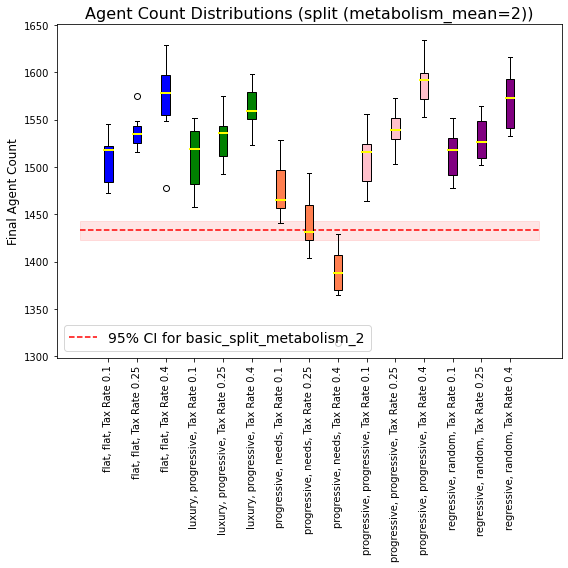

Best combination for split (metabolism_mean=2):
mean_agent    1385.590000
std_agent       33.082908
Name: (progressive, needs, 0.4), dtype: float64
Kruskal-Wallis Test for top_heavy (metabolism_mean=2): H-statistic=103.60163990093753, p-value=9.641770251575452e-16
Significant Comparisons for top_heavy (metabolism_mean=2):
                      combination_1                combination_2  u_statistic  \
0                 (flat, flat, 0.1)            (flat, flat, 0.4)         11.0   
1                 (flat, flat, 0.1)  (luxury, progressive, 0.25)         19.5   
2                 (flat, flat, 0.1)   (luxury, progressive, 0.4)          2.0   
3                 (flat, flat, 0.1)    (progressive, needs, 0.1)         85.0   
4                 (flat, flat, 0.1)   (progressive, needs, 0.25)         95.0   
..                              ...                          ...          ...   
71  (progressive, progressive, 0.4)    (regressive, random, 0.1)         96.0   
72  (progressive, progressiv

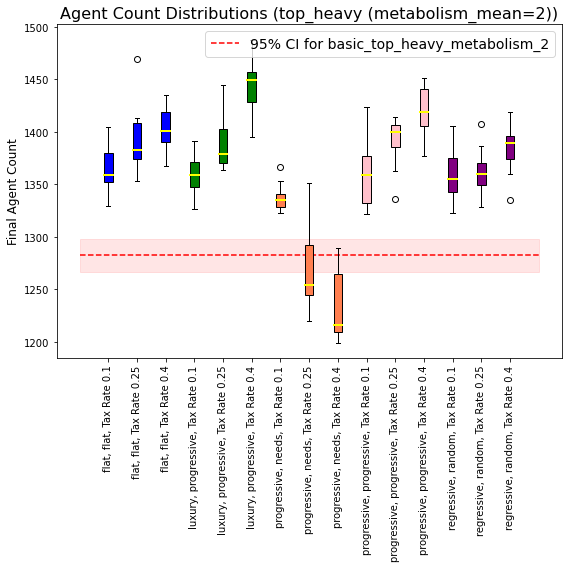

Best combination for top_heavy (metabolism_mean=2):
mean_agent    1234.470000
std_agent       34.046179
Name: (progressive, needs, 0.4), dtype: float64
Kruskal-Wallis Test for uniform (metabolism_mean=2): H-statistic=107.6743141399793, p-value=1.5783717565151988e-16
Significant Comparisons for uniform (metabolism_mean=2):
                       combination_1                combination_2  \
0                  (flat, flat, 0.1)           (flat, flat, 0.25)   
1                  (flat, flat, 0.1)            (flat, flat, 0.4)   
2                  (flat, flat, 0.1)  (luxury, progressive, 0.25)   
3                  (flat, flat, 0.1)   (luxury, progressive, 0.4)   
4                  (flat, flat, 0.1)   (progressive, needs, 0.25)   
..                               ...                          ...   
67  (progressive, progressive, 0.25)   (regressive, random, 0.25)   
68  (progressive, progressive, 0.25)    (regressive, random, 0.4)   
69   (progressive, progressive, 0.4)    (regressive, ra

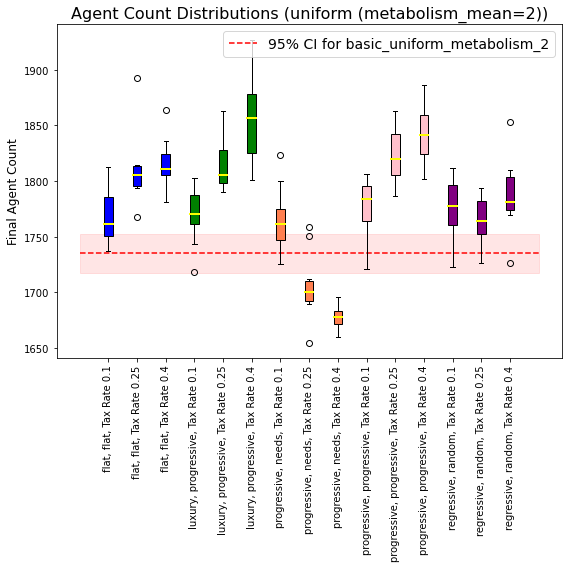

Best combination for uniform (metabolism_mean=2):
mean_agent    1677.155000
std_agent       11.362742
Name: (progressive, needs, 0.4), dtype: float64
Kruskal-Wallis Test for split (metabolism_mean=4): H-statistic=79.70665156657515, p-value=3.2071007517691954e-11
Significant Comparisons for split (metabolism_mean=4):
                       combination_1                     combination_2  \
0                  (flat, flat, 0.1)         (progressive, needs, 0.1)   
1                  (flat, flat, 0.1)        (progressive, needs, 0.25)   
2                  (flat, flat, 0.1)         (progressive, needs, 0.4)   
3                 (flat, flat, 0.25)         (progressive, needs, 0.1)   
4                 (flat, flat, 0.25)        (progressive, needs, 0.25)   
5                 (flat, flat, 0.25)         (progressive, needs, 0.4)   
6                 (flat, flat, 0.25)         (regressive, random, 0.4)   
7                  (flat, flat, 0.4)         (progressive, needs, 0.1)   
8               

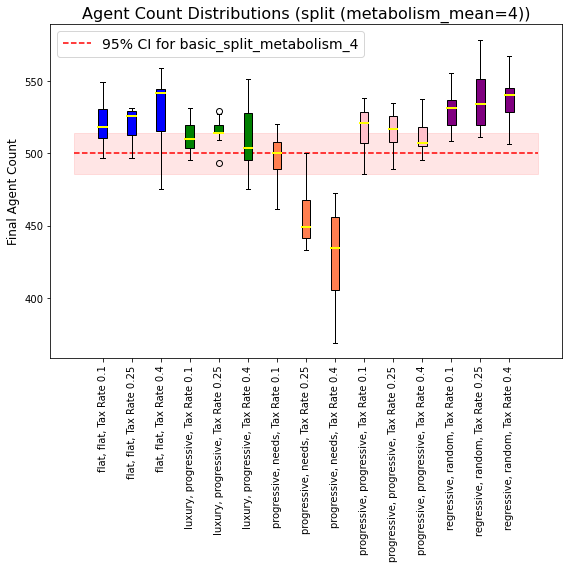

Best combination for split (metabolism_mean=4):
mean_agent    430.225000
std_agent      33.293453
Name: (progressive, needs, 0.4), dtype: float64
Kruskal-Wallis Test for top_heavy (metabolism_mean=4): H-statistic=63.80942583094065, p-value=2.4927788947104237e-08
Significant Comparisons for top_heavy (metabolism_mean=4):
                      combination_1                     combination_2  \
0                 (flat, flat, 0.1)                 (flat, flat, 0.4)   
1                 (flat, flat, 0.1)        (progressive, needs, 0.25)   
2                 (flat, flat, 0.1)         (progressive, needs, 0.4)   
3                (flat, flat, 0.25)                 (flat, flat, 0.4)   
4                (flat, flat, 0.25)        (progressive, needs, 0.25)   
5                (flat, flat, 0.25)         (progressive, needs, 0.4)   
6                 (flat, flat, 0.4)        (luxury, progressive, 0.1)   
7                 (flat, flat, 0.4)       (luxury, progressive, 0.25)   
8                 (fl

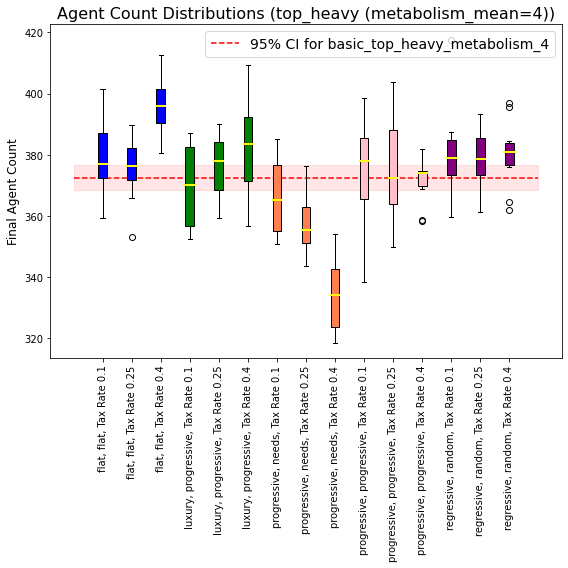

Best combination for top_heavy (metabolism_mean=4):
mean_agent    334.710000
std_agent      13.343929
Name: (progressive, needs, 0.4), dtype: float64
Kruskal-Wallis Test for uniform (metabolism_mean=4): H-statistic=69.60189133113231, p-value=2.2784536033380787e-09
Significant Comparisons for uniform (metabolism_mean=4):
                      combination_1                     combination_2  \
0                 (flat, flat, 0.1)                 (flat, flat, 0.4)   
1                 (flat, flat, 0.1)        (progressive, needs, 0.25)   
2                 (flat, flat, 0.1)         (progressive, needs, 0.4)   
3                 (flat, flat, 0.1)         (regressive, random, 0.4)   
4                (flat, flat, 0.25)         (progressive, needs, 0.1)   
5                (flat, flat, 0.25)        (progressive, needs, 0.25)   
6                (flat, flat, 0.25)         (progressive, needs, 0.4)   
7                 (flat, flat, 0.4)        (luxury, progressive, 0.1)   
8                 (fl

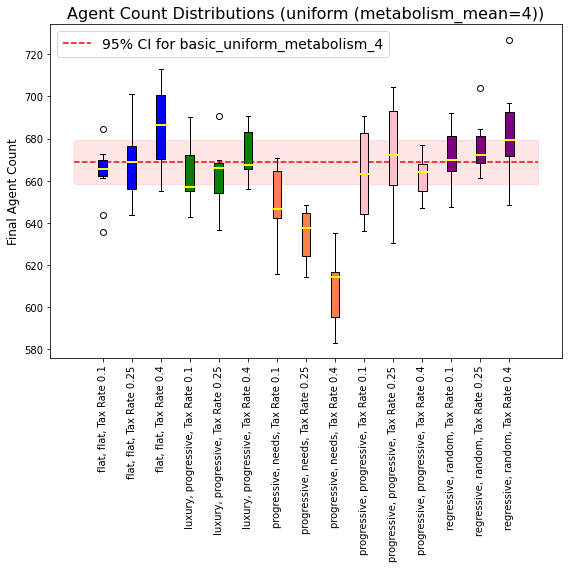

Best combination for uniform (metabolism_mean=4):
mean_agent    609.11500
std_agent      16.05681
Name: (progressive, needs, 0.4), dtype: float64


In [28]:

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from src.SugarScape import SugarScape

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger("simulation")
    handler = logging.FileHandler("simulation.log")
    formatter = logging.Formatter('%(asctime)s - %(levellevelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def load_and_process(file_path):
    """Load CSV file and process the data."""
    data = pd.read_csv(file_path)
    
    def convert_str_to_list(list_str):
        list_str = list_str.strip('[]')
        list_str = list_str.split(',')
        return [float(x.strip()) for x in list_str]

    # Apply the conversion to the relevant columns
    data['Agents Over Time'] = data['Agents Over Time'].apply(convert_str_to_list)
    
    return data

def calculate_ci(data, confidence=0.95):
    """Calculate the 95% confidence interval for the final agent count."""
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data) / np.sqrt(n)
    h = sem * 1.96  # 95% confidence interval
    return mean - h, mean + h

def summarize_significant_results(results):
    """Summarize significant comparisons with p-values."""
    significant_results = [res for res in results if res['p_value'] < 0.05]
    summary = pd.DataFrame(significant_results)
    return summary

def visualize_agent_distributions(data, title, ci):
    """Visualize agent count distributions using box plots and add CI lines."""
    fig, ax = plt.subplots(figsize=(8, 8))
    data_to_plot = []
    labels = []
    colors = ['blue', 'green', 'coral', 'pink', 'purple']  # Define colors for the groups

    for i, ((tax_scheme, distributer_scheme, tax_rate), group_data) in enumerate(data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate'])):
        final_agent_count = [np.mean(agents[-20:]) for agents in group_data['Agents Over Time']]
        data_to_plot.append(final_agent_count)
        labels.append(f"{tax_scheme}, {distributer_scheme}, Tax Rate {tax_rate}")

    boxprops = dict(color='blue')
    whiskerprops = dict(color='blue')
    capprops = dict(color='blue')
    medianprops = dict(color='yellow', linewidth=2)  # Change the median line to yellow and make it thicker
    
    for i in range(0, len(data_to_plot), 3):
        ax.boxplot(data_to_plot[i:i+3], positions=range(i+1, i+4), patch_artist=True, 
                   boxprops=dict(facecolor=colors[i//3 % len(colors)]),
                   medianprops=medianprops)  # Apply the yellow color for the median line
    
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_ylabel('Final Agent Count', fontsize=12)
    ax.set_title(f'Agent Count Distributions ({title})', fontsize=16)
    
    # Add CI lines
    ax.hlines(y=ci['mean'], xmin=0, xmax=len(labels)+1, colors='red', linestyles='dashed', label=f"95% CI for {ci['model']}")
    ax.fill_between(x=np.arange(0, len(labels)+2), y1=ci['ci_lower'], y2=ci['ci_upper'], color='red', alpha=0.1)
    
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"plots/barplots/living_agent_count_{title}.png", dpi=500, transparent=True)
    plt.show()

def identify_best_combination(data, title):
    """Identify the best combination for reducing agent count."""
    summary = data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate']).agg(
        mean_agent=('Final Agent Count', 'mean'),
        std_agent=('Final Agent Count', 'std')
    ).sort_values(by='mean_agent')
    
    best_combination = summary.iloc[0]
    print(f"Best combination for {title}:")
    print(best_combination)

# Define the metabolism mean values to plot
metabolism_values = [2, 4]

# File paths based on the directory structure provided
base_model_template = 'Base Model Experimental Results/experiments_results_{map_scheme}_metabolism_{metabolism_mean}.csv'
experiment_template = 'Experimental Results/experiments_results_meta={metabolism_mean}_{map_scheme}.csv'
map_schemes = ['split', 'top_heavy', 'uniform']

# Load base model data for CI calculation
base_data = {metabolism_mean: {map_scheme: load_and_process(base_model_template.format(map_scheme=map_scheme, metabolism_mean=metabolism_mean)) for map_scheme in map_schemes} for metabolism_mean in metabolism_values}

# Load experiment data
experiment_data = {metabolism_mean: {map_scheme: load_and_process(experiment_template.format(map_scheme=map_scheme, metabolism_mean=metabolism_mean)) for map_scheme in map_schemes} for metabolism_mean in metabolism_values}

# Calculate CI for base models
ci_lines = {}
for metabolism_mean, data_dict in base_data.items():
    for map_scheme, data in data_dict.items():
        final_agent_count = [np.mean(agents[-20:]) for agents in data['Agents Over Time']]
        ci_lower, ci_upper = calculate_ci(final_agent_count)
        ci_lines[(map_scheme, metabolism_mean)] = {'model': f'basic_{map_scheme}_metabolism_{metabolism_mean}', 'mean': np.mean(final_agent_count), 'ci_lower': ci_lower, 'ci_upper': ci_upper}

# Perform analysis for each map and metabolism mean
for metabolism_mean, data_dict in experiment_data.items():
    for map_scheme, data in data_dict.items():
        subset_data = data
        
        if subset_data.empty:
            print(f"No data for metabolism_mean={metabolism_mean} in {map_scheme}")
            continue

        # Get the final agent count for each run
        subset_data['Final Agent Count'] = subset_data['Agents Over Time'].apply(lambda x: np.mean(x[-20:]))

        # Perform Kruskal-Wallis test
        group_data = [group['Final Agent Count'].values for name, group in subset_data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate'])]
        kruskal_result = kruskal(*group_data)
        print(f"Kruskal-Wallis Test for {map_scheme} (metabolism_mean={metabolism_mean}): H-statistic={kruskal_result.statistic}, p-value={kruskal_result.pvalue}")

        # If significant, perform pairwise comparisons
        results = []
        if kruskal_result.pvalue < 0.05:
            combinations = subset_data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate']).groups.keys()
            combinations = list(combinations)
            for i in range(len(combinations)):
                for j in range(i+1, len(combinations)):
                    group1 = subset_data[(subset_data['Tax Scheme'] == combinations[i][0]) & 
                                        (subset_data['Distributer Scheme'] == combinations[i][1]) & 
                                        (subset_data['Tax Rate'] == combinations[i][2])]['Final Agent Count'].values
                    group2 = subset_data[(subset_data['Tax Scheme'] == combinations[j][0]) & 
                                        (subset_data['Distributer Scheme'] == combinations[j][1]) & 
                                        (subset_data['Tax Rate'] == combinations[j][2])]['Final Agent Count'].values
                    u_statistic, p_value = mannwhitneyu(group1, group2)
                    results.append({
                        'combination_1': combinations[i],
                        'combination_2': combinations[j],
                        'u_statistic': u_statistic,
                        'p_value': p_value
                    })

        # Summarize significant results
        summary = summarize_significant_results(results)
        print(f"Significant Comparisons for {map_scheme} (metabolism_mean={metabolism_mean}):")
        print(summary)

        # Visualize agent count distributions
        visualize_agent_distributions(subset_data, f"{map_scheme} (metabolism_mean={metabolism_mean})", ci_lines[(map_scheme, metabolism_mean)])
        
        # Identify the best combination for reducing agent count
        identify_best_combination(subset_data, f"{map_scheme} (metabolism_mean={metabolism_mean})")


Kruskal-Wallis Test for split (metabolism_mean=2): H-statistic=138.1763178807946, p-value=1.6342034523388872e-22
Significant Comparisons for split (metabolism_mean=2):
                      combination_1                combination_2  u_statistic  \
0                 (flat, flat, 0.1)           (flat, flat, 0.25)        100.0   
1                 (flat, flat, 0.1)            (flat, flat, 0.4)        100.0   
2                 (flat, flat, 0.1)   (luxury, progressive, 0.1)         81.0   
3                 (flat, flat, 0.1)  (luxury, progressive, 0.25)        100.0   
4                 (flat, flat, 0.1)   (luxury, progressive, 0.4)        100.0   
..                              ...                          ...          ...   
87  (progressive, progressive, 0.4)    (regressive, random, 0.1)          0.0   
88  (progressive, progressive, 0.4)   (regressive, random, 0.25)          0.0   
89  (progressive, progressive, 0.4)    (regressive, random, 0.4)          0.0   
90        (regressive,

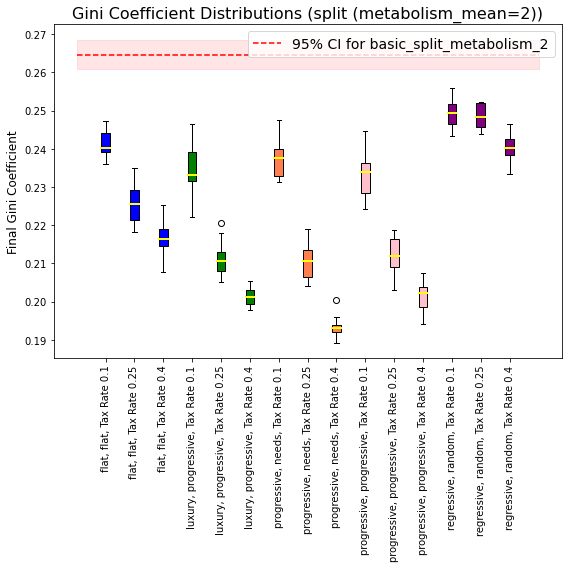

Best combination for split (metabolism_mean=2):
mean_gini    0.193515
std_gini     0.003030
Name: (progressive, needs, 0.4), dtype: float64
Kruskal-Wallis Test for top_heavy (metabolism_mean=2): H-statistic=137.67766887417213, p-value=2.0526286884226825e-22
Significant Comparisons for top_heavy (metabolism_mean=2):
                      combination_1                combination_2  u_statistic  \
0                 (flat, flat, 0.1)           (flat, flat, 0.25)        100.0   
1                 (flat, flat, 0.1)            (flat, flat, 0.4)        100.0   
2                 (flat, flat, 0.1)   (luxury, progressive, 0.1)         99.0   
3                 (flat, flat, 0.1)  (luxury, progressive, 0.25)        100.0   
4                 (flat, flat, 0.1)   (luxury, progressive, 0.4)        100.0   
..                              ...                          ...          ...   
87  (progressive, progressive, 0.4)    (regressive, random, 0.1)          0.0   
88  (progressive, progressive, 0.4)

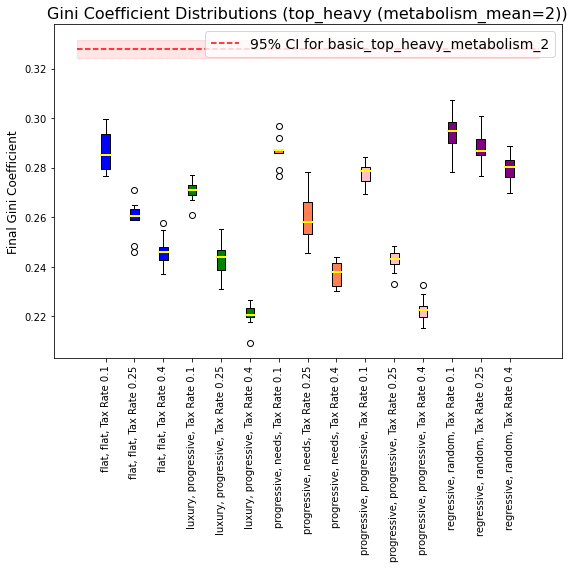

Best combination for top_heavy (metabolism_mean=2):
mean_gini    0.220518
std_gini     0.004765
Name: (luxury, progressive, 0.4), dtype: float64
Kruskal-Wallis Test for uniform (metabolism_mean=2): H-statistic=137.7753642384106, p-value=1.962980871125788e-22
Significant Comparisons for uniform (metabolism_mean=2):
                      combination_1                combination_2  u_statistic  \
0                 (flat, flat, 0.1)           (flat, flat, 0.25)         98.0   
1                 (flat, flat, 0.1)            (flat, flat, 0.4)        100.0   
2                 (flat, flat, 0.1)   (luxury, progressive, 0.1)         86.0   
3                 (flat, flat, 0.1)  (luxury, progressive, 0.25)        100.0   
4                 (flat, flat, 0.1)   (luxury, progressive, 0.4)        100.0   
..                              ...                          ...          ...   
88  (progressive, progressive, 0.4)    (regressive, random, 0.1)          0.0   
89  (progressive, progressive, 0.4) 

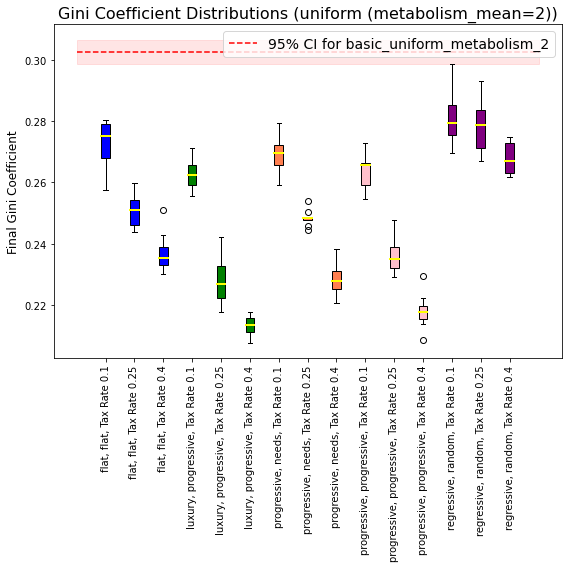

Best combination for uniform (metabolism_mean=2):
mean_gini    0.213482
std_gini     0.003143
Name: (luxury, progressive, 0.4), dtype: float64
Kruskal-Wallis Test for split (metabolism_mean=4): H-statistic=118.54982781456954, p-value=1.209461463715698e-18
Significant Comparisons for split (metabolism_mean=4):
                       combination_1                combination_2  \
0                  (flat, flat, 0.1)           (flat, flat, 0.25)   
1                  (flat, flat, 0.1)            (flat, flat, 0.4)   
2                  (flat, flat, 0.1)  (luxury, progressive, 0.25)   
3                  (flat, flat, 0.1)   (luxury, progressive, 0.4)   
4                  (flat, flat, 0.1)   (progressive, needs, 0.25)   
..                               ...                          ...   
76  (progressive, progressive, 0.25)   (regressive, random, 0.25)   
77  (progressive, progressive, 0.25)    (regressive, random, 0.4)   
78   (progressive, progressive, 0.4)    (regressive, random, 0.1)   

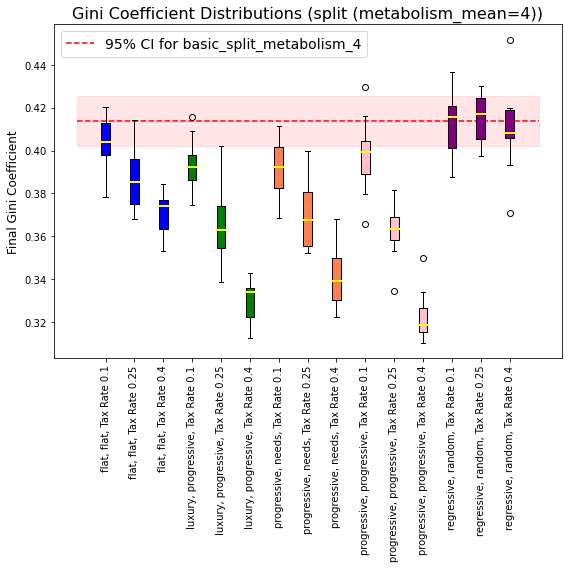

Best combination for split (metabolism_mean=4):
mean_gini    0.322789
std_gini     0.011940
Name: (progressive, progressive, 0.4), dtype: float64
Kruskal-Wallis Test for top_heavy (metabolism_mean=4): H-statistic=108.76588079470207, p-value=9.703747452525018e-17
Significant Comparisons for top_heavy (metabolism_mean=4):
                       combination_1                     combination_2  \
0                  (flat, flat, 0.1)                 (flat, flat, 0.4)   
1                  (flat, flat, 0.1)       (luxury, progressive, 0.25)   
2                  (flat, flat, 0.1)        (luxury, progressive, 0.4)   
3                  (flat, flat, 0.1)         (progressive, needs, 0.4)   
4                  (flat, flat, 0.1)  (progressive, progressive, 0.25)   
..                               ...                               ...   
67  (progressive, progressive, 0.25)         (regressive, random, 0.4)   
68   (progressive, progressive, 0.4)         (regressive, random, 0.1)   
69   (progre

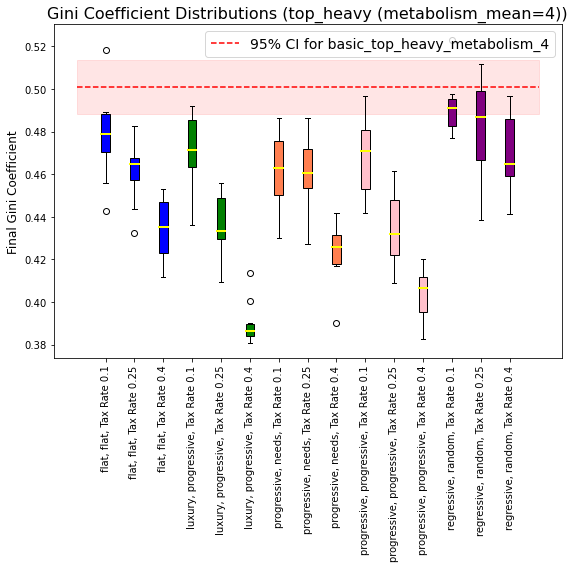

Best combination for top_heavy (metabolism_mean=4):
mean_gini    0.389903
std_gini     0.009980
Name: (luxury, progressive, 0.4), dtype: float64
Kruskal-Wallis Test for uniform (metabolism_mean=4): H-statistic=132.92598675496686, p-value=1.794891314553823e-21
Significant Comparisons for uniform (metabolism_mean=4):
                      combination_1                combination_2  u_statistic  \
0                 (flat, flat, 0.1)           (flat, flat, 0.25)         99.0   
1                 (flat, flat, 0.1)            (flat, flat, 0.4)        100.0   
2                 (flat, flat, 0.1)   (luxury, progressive, 0.1)         80.0   
3                 (flat, flat, 0.1)  (luxury, progressive, 0.25)        100.0   
4                 (flat, flat, 0.1)   (luxury, progressive, 0.4)        100.0   
..                              ...                          ...          ...   
86  (progressive, progressive, 0.4)    (regressive, random, 0.1)          0.0   
87  (progressive, progressive, 0.4)

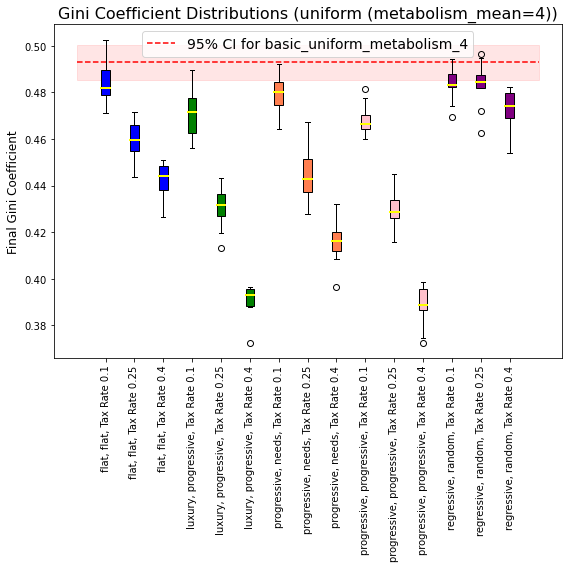

Best combination for uniform (metabolism_mean=4):
mean_gini    0.388186
std_gini     0.008903
Name: (progressive, progressive, 0.4), dtype: float64


In [27]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from src.SugarScape import SugarScape

def setup_logger():
    """Set up a logger for simulation."""
    logger = logging.getLogger("simulation")
    handler = logging.FileHandler("simulation.log")
    formatter = logging.Formatter('%(asctime)s - %(levellevelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)
    return logger

def load_and_process(file_path):
    """Load CSV file and process the data."""
    data = pd.read_csv(file_path)
    
    def convert_str_to_list(list_str):
        list_str = list_str.strip('[]')
        list_str = list_str.split(',')
        return [float(x.strip()) for x in list_str]

    # Apply the conversion to the relevant columns
    data['Gini Over Time'] = data['Gini Over Time'].apply(convert_str_to_list)
    
    return data

def calculate_ci(data, confidence=0.95):
    """Calculate the 95% confidence interval for the final Gini coefficient."""
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data) / np.sqrt(n)
    h = sem * 1.96  # 95% confidence interval
    return mean - h, mean + h

def summarize_significant_results(results):
    """Summarize significant comparisons with p-values."""
    significant_results = [res for res in results if res['p_value'] < 0.05]
    summary = pd.DataFrame(significant_results)
    return summary

def visualize_gini_distributions(data, title, ci):
    """Visualize Gini coefficient distributions using box plots and add CI lines."""
    fig, ax = plt.subplots(figsize=(8, 8))
    data_to_plot = []
    labels = []
    colors = ['blue', 'green', 'coral', 'pink', 'purple']  # Define colors for the groups

    for i, ((tax_scheme, distributer_scheme, tax_rate), group_data) in enumerate(data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate'])):
        final_gini = [np.mean(gini[-20:]) for gini in group_data['Gini Over Time']]
        data_to_plot.append(final_gini)
        labels.append(f"{tax_scheme}, {distributer_scheme}, Tax Rate {tax_rate}")

    boxprops = dict(color='blue')
    whiskerprops = dict(color='blue')
    capprops = dict(color='blue')
    medianprops = dict(color='yellow', linewidth=2)  # Change the median line to yellow and make it thicker
    
    for i in range(0, len(data_to_plot), 3):
        ax.boxplot(data_to_plot[i:i+3], positions=range(i+1, i+4), patch_artist=True, 
                   boxprops=dict(facecolor=colors[i//3 % len(colors)]),
                   medianprops=medianprops)  # Apply the yellow color for the median line
    
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_ylabel('Final Gini Coefficient', fontsize=12)
    ax.set_title(f'Gini Coefficient Distributions ({title})', fontsize=16)
    
    # Add CI lines
    ax.hlines(y=ci['mean'], xmin=0, xmax=len(labels)+1, colors='red', linestyles='dashed', label=f"95% CI for {ci['model']}")
    ax.fill_between(x=np.arange(0, len(labels)+2), y1=ci['ci_lower'], y2=ci['ci_upper'], color='red', alpha=0.1)
    
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"plots/barplots/gini_distributions_{title}.png", dpi=500, transparent=False)
    plt.show()

def identify_best_combination(data, title):
    """Identify the best combination for reducing the Gini coefficient."""
    summary = data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate']).agg(
        mean_gini=('Final Gini Coefficient', 'mean'),
        std_gini=('Final Gini Coefficient', 'std')
    ).sort_values(by='mean_gini')
    
    best_combination = summary.iloc[0]
    print(f"Best combination for {title}:")
    print(best_combination)

# Define the metabolism mean values to plot
metabolism_values = [2, 4]

# File paths based on the directory structure provided
base_model_template = 'Base Model Experimental Results/experiments_results_{map_scheme}_metabolism_{metabolism_mean}.csv'
experiment_template = 'Experimental Results/experiments_results_meta={metabolism_mean}_{map_scheme}.csv'
map_schemes = ['split', 'top_heavy', 'uniform']

# Load base model data for CI calculation
base_data = {metabolism_mean: {map_scheme: load_and_process(base_model_template.format(map_scheme=map_scheme, metabolism_mean=metabolism_mean)) for map_scheme in map_schemes} for metabolism_mean in metabolism_values}

# Load experiment data
experiment_data = {metabolism_mean: {map_scheme: load_and_process(experiment_template.format(map_scheme=map_scheme, metabolism_mean=metabolism_mean)) for map_scheme in map_schemes} for metabolism_mean in metabolism_values}

# Calculate CI for base models
ci_lines = {}
for metabolism_mean, data_dict in base_data.items():
    for map_scheme, data in data_dict.items():
        final_gini = [np.mean(gini[-20:]) for gini in data['Gini Over Time']]
        ci_lower, ci_upper = calculate_ci(final_gini)
        ci_lines[(map_scheme, metabolism_mean)] = {'model': f'basic_{map_scheme}_metabolism_{metabolism_mean}', 'mean': np.mean(final_gini), 'ci_lower': ci_lower, 'ci_upper': ci_upper}

# Perform analysis for each map and metabolism mean
for metabolism_mean, data_dict in experiment_data.items():
    for map_scheme, data in data_dict.items():
        subset_data = data
        
        if subset_data.empty:
            print(f"No data for metabolism_mean={metabolism_mean} in {map_scheme}")
            continue

        # Get the final Gini coefficient for each run
        subset_data['Final Gini Coefficient'] = subset_data['Gini Over Time'].apply(lambda x: np.mean(x[-20:]))

        # Perform Kruskal-Wallis test
        group_data = [group['Final Gini Coefficient'].values for name, group in subset_data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate'])]
        kruskal_result = kruskal(*group_data)
        print(f"Kruskal-Wallis Test for {map_scheme} (metabolism_mean={metabolism_mean}): H-statistic={kruskal_result.statistic}, p-value={kruskal_result.pvalue}")

        # If significant, perform pairwise comparisons
        results = []
        if kruskal_result.pvalue < 0.05:
            combinations = subset_data.groupby(['Tax Scheme', 'Distributer Scheme', 'Tax Rate']).groups.keys()
            combinations = list(combinations)
            for i in range(len(combinations)):
                for j in range(i+1, len(combinations)):
                    group1 = subset_data[(subset_data['Tax Scheme'] == combinations[i][0]) & 
                                        (subset_data['Distributer Scheme'] == combinations[i][1]) & 
                                        (subset_data['Tax Rate'] == combinations[i][2])]['Final Gini Coefficient'].values
                    group2 = subset_data[(subset_data['Tax Scheme'] == combinations[j][0]) & 
                                        (subset_data['Distributer Scheme'] == combinations[j][1]) & 
                                        (subset_data['Tax Rate'] == combinations[j][2])]['Final Gini Coefficient'].values
                    u_statistic, p_value = mannwhitneyu(group1, group2)
                    results.append({
                        'combination_1': combinations[i],
                        'combination_2': combinations[j],
                        'u_statistic': u_statistic,
                        'p_value': p_value
                    })

        # Summarize significant results
        summary = summarize_significant_results(results)
        print(f"Significant Comparisons for {map_scheme} (metabolism_mean={metabolism_mean}):")
        print(summary)

        # Visualize Gini coefficient distributions
        visualize_gini_distributions(subset_data, f"{map_scheme} (metabolism_mean={metabolism_mean})", ci_lines[(map_scheme, metabolism_mean)])
        
        # Identify the best combination for reducing the Gini coefficient
        identify_best_combination(subset_data, f"{map_scheme} (metabolism_mean={metabolism_mean})")


